In [1]:
import pandas as pd
import glob
import numpy as np
import math
from scipy import stats

import matplotlib.pyplot as plt

import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning removal

In [2]:
def running_average(arr, window=5):
    # Compute the running average using convolution
    conv_avg = np.convolve(arr, np.ones(window) / window, mode='valid')
    # Prepend and append additional averages as needed
    start_avgs = [np.mean(arr[:3]), np.mean(arr[:4])]
    end_avgs = [np.mean(arr[-4:]), np.mean(arr[-3:])]
    # Combine everything into one array
    return np.concatenate((start_avgs, conv_avg, end_avgs))

In [3]:
def mk_obs_mo(time_scale):
    dir = '/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/'
    site_list = sorted(glob.glob(dir+'US-*.csv'))
    f_start = 0 ; f_stop = len(site_list)
    
    columns    = ['NETRAD_1_A','LE_1_A','H_1_A','G_1_A','SWC_1_A']
    columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']

    rad_out    =  pd.DataFrame(columns=columns_mo)
    le_out     =  pd.DataFrame(columns=columns_mo)
    sh_out     =  pd.DataFrame(columns=columns_mo)
    gh_out     =  pd.DataFrame(columns=columns_mo)
    swc_out    =  pd.DataFrame(columns=columns_mo)
    
    siteid = []
    
    for s,site in enumerate(site_list[0:f_stop]):
    # for s,site in enumerate(site_list[0:1]):
        f_siteid = site.split("/")[8].split("_")[0][:6]
        df   = pd.read_csv(site,na_values=-9999)
        
        tm      = df['TIME']    
        yrs     = str(tm[0])[:4]   ;    yre     = str(tm[int(len(tm)-1)])[:4]
        mos     = str(tm[0])[4:6]  ;    moe     = str(tm[int(len(tm)-1)])[4:6]
        dys     = str(tm[0])[6:8]  ;    dye     = str(tm[int(len(tm)-1)])[6:8]
        hrs     = str(tm[0])[8:10] ;    hre     = str(tm[int(len(tm)-1)])[8:10]
        mns     = str(tm[0])[10:12];    mne     = str(tm[int(len(tm)-1)])[10:12]

        time = pd.date_range(yrs+'-'+mos+'-'+dys+' '+hrs+':'+mns,yre+'-'+moe+'-'+dye+' '+hre+':'+mne,freq='30MIN')        
        df.index = pd.to_datetime(time)
        
        rad    = df[columns[0]].resample(time_scale).mean()    
        le     = df[columns[1]].resample(time_scale).mean()
        sh     = df[columns[2]].resample(time_scale).mean()
        gh     = df[columns[3]].resample(time_scale).mean()
        swc1   = df[columns[4]].resample(time_scale).mean()
        
        sort_nan = ~np.logical_or.reduce((np.isnan(rad),np.isnan(le),np.isnan(sh),np.isnan(gh),np.isnan(swc1)))
    
        tm_indx = rad.index[sort_nan]
        month = rad.index.month[sort_nan]
        rad   = rad[sort_nan]
        le    = le [sort_nan]
        sh    = sh [sort_nan]
        gh    = gh [sort_nan]        
        swc1  = swc1[sort_nan]
        
        if int(yre) > 2020:
            month = month[rad.index.year <= 2020]
            rad = rad[rad.index.year <= 2020]
            le  = le [le.index.year <= 2020]
            sh  = sh [sh.index.year <= 2020]
            gh  = gh [gh.index.year <= 2020]
            swc1= swc1[swc1.index.year <= 2020]
        
        if int(yrs) < 2021:
            rad_monthly  = []
            le_monthly   = []
            sh_monthly   = []
            gh_monthly   = []
            swc_monthly  = []
        
            for i in range(1,13):
                if (len(rad[month == i]) >= 90.):
                    rad_mo   = np.nanmedian(running_average(rad[month == i]))
                    le_mo    = np.nanmedian(running_average(le[month == i]))
                    sh_mo    = np.nanmedian(running_average(sh[month == i]))
                    gh_mo    = np.nanmedian(running_average(gh[month == i]))
                    swc_mo   = np.nanmedian(running_average(swc1[month == i]))
                else:
                    rad_mo    = np.nan
                    le_mo     = np.nan
                    sh_mo     = np.nan
                    gh_mo     = np.nan
                    swc_mo    = np.nan
     
                rad_monthly.append(rad_mo)
                le_monthly.append(le_mo)
                sh_monthly.append(sh_mo)
                gh_monthly.append(gh_mo)
                swc_monthly.append(swc_mo)
 
            rad_in  = pd.DataFrame([rad_monthly], columns=columns_mo)
            le_in   = pd.DataFrame([le_monthly], columns=columns_mo)
            sh_in   = pd.DataFrame([sh_monthly], columns=columns_mo)
            gh_in   = pd.DataFrame([gh_monthly], columns=columns_mo)
            swc_in  = pd.DataFrame([swc_monthly], columns=columns_mo)
            
            rad_out   = pd.concat([rad_out,rad_in], ignore_index=True)
            le_out    = pd.concat([le_out,le_in], ignore_index=True)
            sh_out    = pd.concat([sh_out,sh_in], ignore_index=True)
            gh_out    = pd.concat([gh_out,gh_in], ignore_index=True)
            swc_out    = pd.concat([swc_out,swc_in], ignore_index=True)            
        
            siteid.append(f_siteid)
            del df
        
    
    print('done')
    return swc_out, rad_out, le_out, sh_out, gh_out, siteid

In [4]:
obs = mk_obs_mo('1D')

done


In [5]:
swc_obs  = obs[0]
rad_obs  = obs[1]
le_obs   = obs[2]
sh_obs   = obs[3]
gh_obs   = obs[4]
site_obs = obs[5]

In [6]:
def get_obs_info(info,obs,f_siteid):
    columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']
    var_ssnl   = []
    
    dir = '/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/site/'
    df  = pd.read_csv(dir+f_siteid+'_site.csv',na_values=-9999)
    
    for i in range(1,13):
        value = obs.iloc[s][str(i)]
        if value is None or math.isnan(value):  # Skip if the value is None or NaN
            var_mo  = np.nan
        else:
            var_mo  = df[info].item()
            
        var_ssnl.append(var_mo)
        
    var_out  = pd.DataFrame(np.array([var_ssnl]), columns=columns_mo)
    
    return var_out

In [7]:
list = site_obs
f_start = 0 ; f_stop = len(list)

columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']

lat_obs    =  pd.DataFrame(columns=columns_mo)
lon_obs    =  pd.DataFrame(columns=columns_mo)
igbp_obs   =  pd.DataFrame(columns=columns_mo)

for s,site in enumerate(list[f_start:f_stop]):
    f_siteid = list[s]
    # print(f_siteid)
    lon_in  = get_obs_info('Longitude',le_obs,f_siteid)
    lat_in  = get_obs_info('Latitude' ,le_obs,f_siteid)
    igbp_in = get_obs_info('IGBP type',le_obs,f_siteid)
    
    lon_obs  = pd.concat([lon_obs, lon_in], ignore_index=True)
    lat_obs  = pd.concat([lat_obs, lat_in], ignore_index=True)
    igbp_obs = pd.concat([igbp_obs,igbp_in], ignore_index=True)

    # print(loc_obs)
print('done')

done


In [8]:
lat_maskout = lat_obs <= 50
swc_obs   = swc_obs[lat_maskout]
rad_obs   = rad_obs[lat_maskout]
le_obs    = le_obs [lat_maskout]
sh_obs    = sh_obs [lat_maskout]
gh_obs    = gh_obs [lat_maskout]
print(swc_obs.count())


1     52
2     47
3     57
4     54
5     57
6     59
7     64
8     67
9     64
10    66
11    58
12    60
dtype: int64


In [9]:
def mk_sort_nan(site):
    dir     = '/projects/COLA/land/skim/FLUXNET/AMERIbase/out_v2/'
    # dir     = '/projects/COLA/land/skim/ameribase_skim/'
    columns = ['NETRAD_1_A','LE_1_A','H_1_A','G_1_A','SWC_1_A']
    df   = pd.read_csv(dir+site+'.csv',na_values=-9999)    
        
    tm      = df['TIME']    
    yrs     = str(tm[0])[:4]   ;    yre     = str(tm[int(len(tm)-1)])[:4]
    mos     = str(tm[0])[4:6]  ;    moe     = str(tm[int(len(tm)-1)])[4:6]
    dys     = str(tm[0])[6:8]  ;    dye     = str(tm[int(len(tm)-1)])[6:8]
    hrs     = str(tm[0])[8:10] ;    hre     = str(tm[int(len(tm)-1)])[8:10]
    mns     = str(tm[0])[10:12];    mne     = str(tm[int(len(tm)-1)])[10:12]

    time = pd.date_range(yrs+'-'+mos+'-'+dys+' '+hrs+':'+mns,yre+'-'+moe+'-'+dye+' '+hre+':'+mne,freq='30MIN')        
    df.index = pd.to_datetime(time)

    rad    = df[columns[0]].resample('1D').mean()    
    le     = df[columns[1]].resample('1D').mean()
    sh     = df[columns[2]].resample('1D').mean()
    gh     = df[columns[3]].resample('1D').mean()
    swc1   = df[columns[4]].resample('1D').mean()

    if int(yre) > 2020:            
        rad = rad[rad.index.year <= 2020]
        le  = le [le.index.year <= 2020]
        sh  = sh [sh.index.year <= 2020]
        gh  = gh [gh.index.year <= 2020]
        swc1= swc1[swc1.index.year <= 2020]

        
    sort_nan = ~np.logical_or.reduce((np.isnan(rad),np.isnan(le),np.isnan(sh),np.isnan(gh),np.isnan(swc1)))
    
    return sort_nan

In [10]:
def mk_mo(obs, var, s, month):
    columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']

    var_ssnl = []
    for i in range(1, 13):
        value = obs.iloc[s][str(i)]
        if value is None or math.isnan(value):
            var_mo = np.nan
        else:
            var_mo = np.nanmedian(running_average(var[month == i]))
            # .median()  # Ensure 'month' is defined or passed appropriately.
        var_ssnl.append(var_mo)
    # print(var_ssnl)
    var_in = pd.DataFrame([var_ssnl], columns=columns_mo)

    return var_in

In [11]:
def mk_era_mo(time_scale):
    
    columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']

    rad_out    =  pd.DataFrame(columns=columns_mo)
    le_out     =  pd.DataFrame(columns=columns_mo)
    sh_out     =  pd.DataFrame(columns=columns_mo)
    gh_out     =  pd.DataFrame(columns=columns_mo)
    swc_out    =  pd.DataFrame(columns=columns_mo)   
    dir = '/projects/COLA/land/skim/FLUXNET/AMERIbase/era5/out_v2/LE_1_A/'
    site_list = sorted(glob.glob(dir+'US-*csv'))    

    for s,site in enumerate(site_list[:]):
    # for s,site in enumerate(site_list[8:9]):
        # print(site_list)
        f_siteid = site.split("/")[10].split("_")[0][:6]
        # print(s,f_siteid)

        dir1  = '/projects/COLA/land/skim/FLUXNET/AMERIbase/era5/out_v2/'
        df1   = pd.read_csv(dir1+'/LE_1_A/'+f_siteid+'.csv',na_values=-9999)
        df2   = pd.read_csv(dir1+'/H_1_A/'+f_siteid+'.csv',na_values=-9999)
        # df3   = pd.read_csv(dir1+'/GH_1_A/'+f_siteid+'.csv',na_values=-9999)
        df4   = pd.read_csv(dir1+'/SWC_1_A/'+f_siteid+'.csv',na_values=-9999)
        df5   = pd.read_csv(dir1+'/SW_1_A/'+f_siteid+'.csv',na_values=-9999)
        df6   = pd.read_csv(dir1+'/LW_1_A/'+f_siteid+'.csv',na_values=-9999)

        tm      = df1['TIME']    
        yrs     = str(tm[0])[:4]   ;    yre     = str(tm[int(len(tm)-1)])[:4]
        mos     = str(tm[0])[5:7]  ;    moe     = str(tm[int(len(tm)-1)])[5:7]
        dys     = str(tm[0])[8:10]  ;    dye     = str(tm[int(len(tm)-1)])[8:10]
        hrs     = str(tm[0])[11:13] ;    hre     = str(tm[int(len(tm)-1)])[11:13]
        mns     = str(tm[0])[14:16];    mne     = str(tm[int(len(tm)-1)])[14:16]
        # print(f_siteid,yrs, mos, yre, moe)

        time  = pd.date_range(yrs+'-'+mos+'-'+dys,yre+'-'+moe+'-'+dye,freq='1D')   
        df1.index = pd.to_datetime(time)
        df2.index = pd.to_datetime(time)
        # df3.index = pd.to_datetime(time)
        df4.index = pd.to_datetime(time)
        df5.index = pd.to_datetime(time)
        df6.index = pd.to_datetime(time)  

        le   = df1['LE_1_A']
        sh   = df2['H_1_A']
        # gh   = df3['GH_1_A'][sort_nan]
        swc  = df4['SWC_1_A']
        sw   = df5['SW_1_A']
        lw   = df6['LW_1_A']
        rad  = sw + lw
        gh   = rad - (le + sh)

        month = le.index.month
        sort_nan = mk_sort_nan(f_siteid)
        
        if (len(le.values) > len(sort_nan)):
            min_len = min(len(month.values), len(sort_nan))
            month = month[:min_len]
            rad   = rad[:min_len]
            le    = le [:min_len]
            sh    = sh [:min_len]
            gh    = gh [:min_len]
            swc   = swc[:min_len]                

            month = month[sort_nan]
            rad   = rad[sort_nan]
            le    = le [sort_nan]
            sh    = sh [sort_nan]
            gh    = gh [sort_nan]
            swc   = swc[sort_nan]

            del min_len
        else:
            month = month[sort_nan]
            rad   = rad[sort_nan]
            le    = le [sort_nan]
            sh    = sh [sort_nan]
            gh    = gh [sort_nan]
            swc   = swc[sort_nan]
    
        rad_in = mk_mo(rad_obs, rad, s, month)
        le_in  = mk_mo(le_obs , le, s, month)
        sh_in  = mk_mo(sh_obs , sh, s, month)
        gh_in  = mk_mo(gh_obs , gh, s, month)
        swc_in = mk_mo(swc_obs, swc, s, month)

        rad_out   = pd.concat([rad_out,rad_in], ignore_index=True)
        le_out    = pd.concat([le_out,le_in], ignore_index=True)
        sh_out    = pd.concat([sh_out,sh_in], ignore_index=True)
        gh_out    = pd.concat([gh_out,gh_in], ignore_index=True)
        swc_out    = pd.concat([swc_out,swc_in], ignore_index=True)            

        del df1
        del df2
        # del df3
        del df4
        del df5
        del df6

    
    print('done')
    return swc_out, rad_out, le_out, sh_out, gh_out

In [12]:
era = mk_era_mo('1D')

done


In [13]:
swc_era  = era[0] * 100.
rad_era  = era[1]
le_era   = era[2]
sh_era   = era[3]
gh_era   = era[4]

In [14]:
def mk_merra_mo(time_scale):
    
    columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']

    rad_out    =  pd.DataFrame(columns=columns_mo)
    le_out     =  pd.DataFrame(columns=columns_mo)
    sh_out     =  pd.DataFrame(columns=columns_mo)
    gh_out     =  pd.DataFrame(columns=columns_mo)
    swc_out    =  pd.DataFrame(columns=columns_mo)   
    dir = '/projects/COLA/land/skim/FLUXNET/AMERIbase/merra2/out_v2/LE_1_A/'
    site_list = sorted(glob.glob(dir+'US-*csv'))    

    for s,site in enumerate(site_list[:]):
    # for s,site in enumerate(site_list[8:9]):
        # print(site_list)
        f_siteid = site.split("/")[10].split("_")[0][:6]
        # print(s,f_siteid)

        dir1  = '/projects/COLA/land/skim/FLUXNET/AMERIbase/merra2/out_v2/'
        df1   = pd.read_csv(dir1+'/LE_1_A/'+f_siteid+'.csv',na_values=-9999)
        df2   = pd.read_csv(dir1+'/H_1_A/'+f_siteid+'.csv',na_values=-9999)
        df3   = pd.read_csv(dir1+'/GH_1_A/'+f_siteid+'.csv',na_values=-9999)
        df4   = pd.read_csv(dir1+'/SWC_1_A/'+f_siteid+'.csv',na_values=-9999)
        df5   = pd.read_csv(dir1+'/SW_1_A/'+f_siteid+'.csv',na_values=-9999)
        df6   = pd.read_csv(dir1+'/LW_1_A/'+f_siteid+'.csv',na_values=-9999)

        tm      = df1['TIME']    
        yrs     = str(tm[0])[:4]   ;    yre     = str(tm[int(len(tm)-1)])[:4]
        mos     = str(tm[0])[5:7]  ;    moe     = str(tm[int(len(tm)-1)])[5:7]
        dys     = str(tm[0])[8:10]  ;    dye     = str(tm[int(len(tm)-1)])[8:10]
        hrs     = str(tm[0])[11:13] ;    hre     = str(tm[int(len(tm)-1)])[11:13]
        mns     = str(tm[0])[14:16];    mne     = str(tm[int(len(tm)-1)])[14:16]
        # print(f_siteid,yrs, mos, yre, moe)

        time  = pd.date_range(yrs+'-'+mos+'-'+dys,yre+'-'+moe+'-'+dye,freq='1D')   
        df1.index = pd.to_datetime(time)
        df2.index = pd.to_datetime(time)
        df3.index = pd.to_datetime(time)
        df4.index = pd.to_datetime(time)
        df5.index = pd.to_datetime(time)
        df6.index = pd.to_datetime(time)  

        # if (df1.columns[1] == 'GH_1_A'):
        #     le   = df1['GH_1_A']
        # else:
        le   = df1['LE_1_A']

        # if (df2.columns[1] == 'GH_1_A'):
        #     sh   = df2['GH_1_A']
        # else:
        sh   = df2['H_1_A']

        # if (df4.columns[1] == 'GH_1_A'):
        #     swc   = df4['GH_1_A']
        # else:
        swc   = df4['SWC_1_A']

        # if (df5.columns[1] == 'GH_1_A'):
        #     sw   = df5['GH_1_A']
        # else:
        sw   = df5['SW_1_A']

        # if (df6.columns[1] == 'GH_1_A'):
        #     lw   = df6['GH_1_A']
        # else:
        lw   = df6['LW_1_A']
            
        gh   = df3['GH_1_A']
        rad  = sw + lw
        # gh   = rad - (le + sh)

        month = le.index.month
        sort_nan = mk_sort_nan(f_siteid)
        
        if (len(le.values) > len(sort_nan)):
            min_len = min(len(month.values), len(sort_nan))
            month = month[:min_len]
            rad   = rad[:min_len]
            le    = le [:min_len]
            sh    = sh [:min_len]
            gh    = gh [:min_len]
            swc   = swc[:min_len]                

            month = month[sort_nan]
            rad   = rad[sort_nan]
            le    = le [sort_nan]
            sh    = sh [sort_nan]
            gh    = gh [sort_nan]
            swc   = swc[sort_nan]

            del min_len
        else:
            month = month[sort_nan]
            rad   = rad[sort_nan]
            le    = le [sort_nan]
            sh    = sh [sort_nan]
            gh    = gh [sort_nan]
            swc   = swc[sort_nan]
    
        rad_in = mk_mo(rad_obs, rad, s, month)
        le_in  = mk_mo(le_obs , le, s, month)
        sh_in  = mk_mo(sh_obs , sh, s, month)
        gh_in  = mk_mo(gh_obs , gh, s, month)
        swc_in = mk_mo(swc_obs, swc, s, month)

        rad_out   = pd.concat([rad_out,rad_in], ignore_index=True)
        le_out    = pd.concat([le_out,le_in], ignore_index=True)
        sh_out    = pd.concat([sh_out,sh_in], ignore_index=True)
        gh_out    = pd.concat([gh_out,gh_in], ignore_index=True)
        swc_out    = pd.concat([swc_out,swc_in], ignore_index=True)            

        del df1
        del df2
        # del df3
        del df4
        del df5
        del df6

    
    print('done')
    return swc_out, rad_out, le_out, sh_out, gh_out

In [15]:
merra = mk_merra_mo('1D')

done


In [16]:
swc_merra  = merra[0] * 100.
rad_merra  = merra[1]
le_merra   = merra[2]
sh_merra   = merra[3]
gh_merra   = merra[4]

In [17]:
def mk_clm_mo(var,obs,f_siteid):
    columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']
    var_ssnl = []
    
    dir = '/projects/COLA/land/skim/FLUXNET/AMERIbase/cesm/clm/out_v2'
    model_len = 8761
    df  = pd.read_csv(dir+'/'+str(var)+'/'+f_siteid+'.csv',na_values=-9999)[:model_len]
    # print(df)
    
    df['YEAR']  = df['TIME'].str.slice(0, 4).astype(int)    # Extract the year
    df['MONTH'] = df['TIME'].str.slice(5, 7).astype(int)   # Extract the month
    df['DAY']   = df['TIME'].str.slice(8, 10).astype(int)    # Extract the day
    # print(running_average(df.groupby('MONTH')[var]))
    # vars = df.groupby('MONTH')[var]
    vars = df.groupby('MONTH')[var]

    # .median()
    # print(vars)
    
    for i in range(1,13):
        value = obs.iloc[s][str(i)]
        if value is None or math.isnan(value):  # Skip if the value is None or NaN
            var_mo = np.nan
        else:
            # var_mo = vars[month == i].median()
            # var_mo = vars[i]
            var_mo = np.nanmedian(running_average(vars.get_group(i)))

        var_ssnl.append(var_mo)

    var_in = pd.DataFrame(np.array([var_ssnl]), columns=columns_mo)
    return var_in

In [18]:
list = site_obs
f_start = 0 ; f_stop = len(list)

columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']

rad_clm    =  pd.DataFrame(columns=columns_mo)
le_clm     =  pd.DataFrame(columns=columns_mo)
sh_clm     =  pd.DataFrame(columns=columns_mo)
gh_clm     =  pd.DataFrame(columns=columns_mo)
swc_clm    =  pd.DataFrame(columns=columns_mo)

for s,site in enumerate(list[f_start:f_stop]):
# for s,site in enumerate(list[0:10]):
    # f_siteid = site.split("/")[8].split("_")[0][:6]
    f_siteid = list[s]
    # print(f_siteid)
    le_in  = mk_clm_mo('LE_1_A',le_obs,f_siteid)
    sh_in  = mk_clm_mo('H_1_A',sh_obs,f_siteid)
    gh_in  = mk_clm_mo('GH_1_A',gh_obs,f_siteid)
    swc_in = mk_clm_mo('SWC_1_A',swc_obs,f_siteid)
    rad_in = mk_clm_mo('Rn_1_A',rad_obs,f_siteid)
     
    rad_clm   = pd.concat([rad_clm,rad_in], ignore_index=True)
    le_clm    = pd.concat([le_clm,le_in], ignore_index=True)
    sh_clm    = pd.concat([sh_clm,sh_in], ignore_index=True)
    gh_clm    = pd.concat([gh_clm,gh_in], ignore_index=True)
    swc_clm   = pd.concat([swc_clm,swc_in], ignore_index=True)
print('done')

/tmp/ipykernel_1818084/252313950.py:27: RuntimeWarning: All-NaN slice encountered
  var_mo = np.nanmedian(running_average(vars.get_group(i)))
/tmp/ipykernel_1818084/252313950.py:27: RuntimeWarning: All-NaN slice encountered
  var_mo = np.nanmedian(running_average(vars.get_group(i)))
/tmp/ipykernel_1818084/252313950.py:27: RuntimeWarning: All-NaN slice encountered
  var_mo = np.nanmedian(running_average(vars.get_group(i)))
/tmp/ipykernel_1818084/252313950.py:27: RuntimeWarning: All-NaN slice encountered
  var_mo = np.nanmedian(running_average(vars.get_group(i)))
/tmp/ipykernel_1818084/252313950.py:27: RuntimeWarning: All-NaN slice encountered
  var_mo = np.nanmedian(running_average(vars.get_group(i)))


done


In [19]:
def mk_amip_mo(var,obs,f_siteid):
    columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']
    var_ssnl = []
    
    dir = '/projects/COLA/land/skim/FLUXNET/AMERIbase/cesm/amip/out_v2'
    model_len = 8761
    df  = pd.read_csv(dir+'/'+str(var)+'/'+f_siteid+'.csv',na_values=-9999)[:model_len]
    
    df['YEAR']  = df['TIME'].str.slice(0, 4).astype(int)    # Extract the year
    df['MONTH'] = df['TIME'].str.slice(5, 7).astype(int)   # Extract the month
    df['DAY']   = df['TIME'].str.slice(8, 10).astype(int)    # Extract the day
    
    # vars = df.groupby('MONTH')[var].median()
    vars = df.groupby('MONTH')[var]
    
    for i in range(1,13):
        value = obs.iloc[s][str(i)]
        if value is None or math.isnan(value):  # Skip if the value is None or NaN
            var_mo = np.nan
        else:
            # var_mo = vars[month == i]
            # var_mo = vars[i]
            var_mo = np.nanmedian(running_average(vars.get_group(i)))


        var_ssnl.append(var_mo)

    var_in = pd.DataFrame(np.array([var_ssnl]), columns=columns_mo)
    return var_in


In [20]:
list = site_obs
f_start = 0 ; f_stop = len(list)

columns_mo = ['1','2','3','4','5','6','7','8','9','10','11','12']

rad_amip    =  pd.DataFrame(columns=columns_mo)
le_amip     =  pd.DataFrame(columns=columns_mo)
sh_amip     =  pd.DataFrame(columns=columns_mo)
gh_amip     =  pd.DataFrame(columns=columns_mo)
swc_amip    =  pd.DataFrame(columns=columns_mo)

for s,site in enumerate(list[f_start:f_stop]):
# for s,site in enumerate(list[0:2]):
    # f_siteid = site.split("/")[8].split("_")[0][:6]
    f_siteid = list[s]
    # print(f_siteid)
    le_in  = mk_amip_mo('LE_1_A',le_obs,f_siteid)
    sh_in  = mk_amip_mo('H_1_A',sh_obs,f_siteid)
    gh_in  = mk_amip_mo('GH_1_A',gh_obs,f_siteid)
    swc_in = mk_amip_mo('SWC_1_A',swc_obs,f_siteid)
    rad_in = mk_amip_mo('Rn_1_A',rad_obs,f_siteid)
     
    rad_amip   = pd.concat([rad_amip,rad_in], ignore_index=True)
    le_amip    = pd.concat([le_amip,le_in], ignore_index=True)
    sh_amip    = pd.concat([sh_amip,sh_in], ignore_index=True)
    gh_amip    = pd.concat([gh_amip,gh_in], ignore_index=True)
    swc_amip   = pd.concat([swc_amip,swc_in], ignore_index=True)
print('done')

/tmp/ipykernel_1818084/3665743724.py:23: RuntimeWarning: All-NaN slice encountered
  var_mo = np.nanmedian(running_average(vars.get_group(i)))
/tmp/ipykernel_1818084/3665743724.py:23: RuntimeWarning: All-NaN slice encountered
  var_mo = np.nanmedian(running_average(vars.get_group(i)))
/tmp/ipykernel_1818084/3665743724.py:23: RuntimeWarning: All-NaN slice encountered
  var_mo = np.nanmedian(running_average(vars.get_group(i)))


done


In [21]:
ef_obs   = le_obs / (le_obs + sh_obs)
ef_merra = le_merra  / (le_merra  + sh_merra )
ef_era   = le_era / (le_era + sh_era)
ef_clm   = le_clm / (le_clm + sh_clm)
ef_amip  = le_amip / (le_amip + sh_amip)

ef_obs_median   = ef_obs.median()
ef_merra_median = ef_merra.median()
ef_era_median   = ef_era.median()
ef_clm_median   = ef_clm.median()
ef_amip_median  = ef_amip.median()

swc_obs_median   = swc_obs.median()
swc_merra_median = swc_merra.median()
swc_era_median   = swc_era.median()
swc_clm_median   = swc_clm.median()
swc_amip_median  = swc_amip.median()

In [22]:
def annotate_month(ax, x, y, month_label, i, fontsize=10):
    """
    ax: axes object
    x, y: coordinates for the text
    month_label: the text to display (like 'Jan', 'Feb', etc. or an integer)
    i: index of the month (0-based)
    """
    # Decide color, alpha, bold, etc. based on i
    if 2 <= i < 8:
        text = ax.text(x, y, month_label,
                       fontsize=fontsize,
                       ha='center',
                       va='center',
                       color='red',
                       fontweight='bold')
        outline = [path_effects.Stroke(linewidth=2, foreground='black'),
                   path_effects.Normal()]
        text.set_path_effects(outline)
    elif i == 11:
        text = ax.text(x, y, month_label,
                       fontsize=fontsize,
                       ha='center',
                       va='center',
                       color='blue',
                       fontweight='bold')
        outline = [path_effects.Stroke(linewidth=2, foreground='black'),
                   path_effects.Normal()]
        text.set_path_effects(outline)
    else:
        # default alpha=0.5
        ax.text(x, y, month_label,
                fontsize=fontsize,
                ha='center',
                va='center',
                alpha=0.5)
        
def cycle_data(arr):
    """
    Takes the last element of arr, then the first 8 elements, 
    and concatenates them in that order.
    """
    # return np.concatenate(([arr[-1]], arr[:8]))
    
    return np.concatenate(([arr[0]], arr[:8]))

In [23]:
import matplotlib.patheffects as path_effects

months = np.arange(12)

# Suppose you have four rows for Rn, LE, SH, GH
# (You also have swc on the x-axis in each subplot.)
variables = [
    ("Rn"," [W m$^{-2}$]", 0, "rad"),  # row label, row index, key name for Y data
    ("LE"," [W m$^{-2}$]", 1, "le"),
    ("SH"," [W m$^{-2}$]", 2, "sh"),
    ("GH"," [W m$^{-2}$]", 3, "gh"),
    ("EF"," [-]", 4, "ef"),]

# Suppose you have four columns for OBS, MERRA2, ERA5, CLM
# Each entry's value is another dict with the median arrays
# e.g. 'swc' -> swc_obs_median.values, 'rad' -> rad_obs.median().values, etc.
datasets = {
    "(a) OBS": {
        "swc": swc_obs_median.values,
        "rad": rad_obs.median().values,
        "le":  le_obs.median().values,
        "sh":  sh_obs.median().values,
        "gh":  gh_obs.median().values,
        "ef":  ef_obs_median.values,
    },
    "(b) MERRA2": {
        "swc": swc_merra_median.values,
        "rad": rad_merra.median().values,
        "le":  le_merra.median().values,
        "sh":  sh_merra.median().values,
        "gh":  gh_merra.median().values,
        "ef":  ef_merra_median.values,
},
    "(c) ERA5": {
        "swc": swc_era_median.values,
        "rad": rad_era.median().values,
        "le":  le_era.median().values,
        "sh":  sh_era.median().values,
        "gh":  gh_era.median().values,
        "ef":  ef_era_median.values,
},
    "(d) CLM": {
        "swc": swc_clm_median.values,
        "rad": rad_clm.median().values,
        "le":  le_clm.median().values,
        "sh":  sh_clm.median().values,
        "gh":  gh_clm.median().values,
        "ef":  ef_clm_median.values,
},
    "(e) CLM+CAM": {
        "swc": swc_amip_median.values,
        "rad": rad_amip.median().values,
        "le":  le_amip.median().values,
        "sh":  sh_amip.median().values,
        "gh":  gh_amip.median().values,
        "ef":  ef_amip_median.values,
},
}

FIG2.

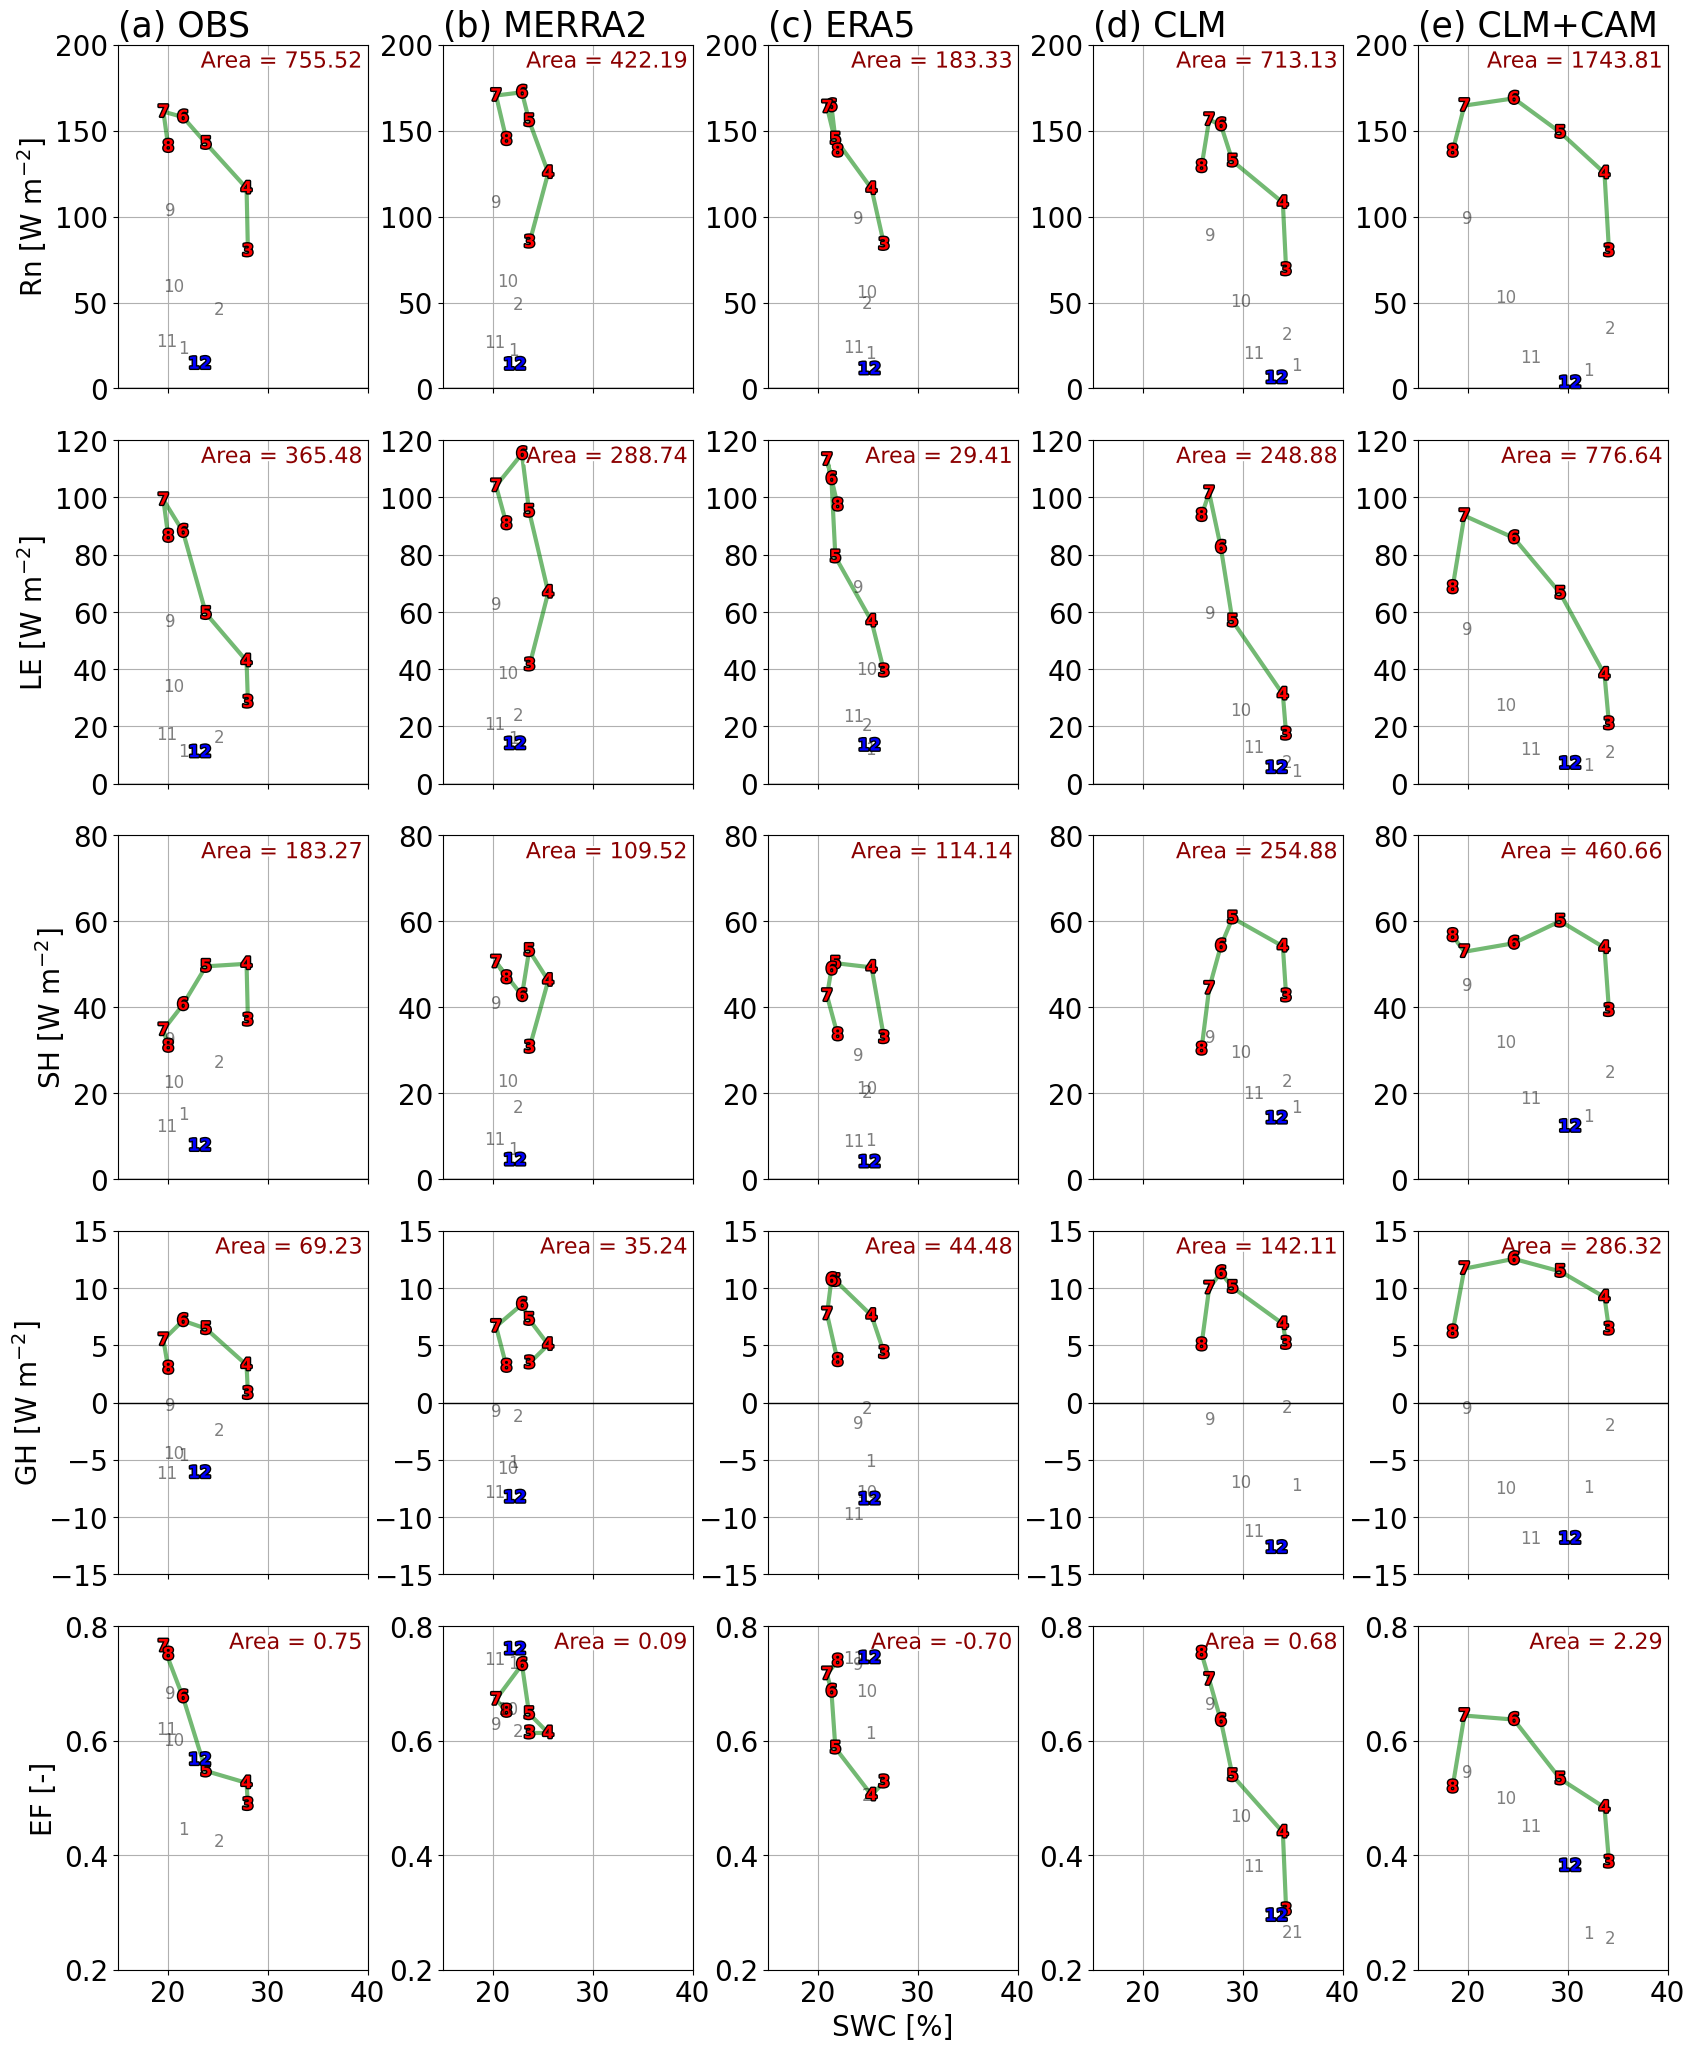

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects


def signed_area(xy):
    """
    xy = list of (x,y)
    returns signed polygon area
    """
    x, y = zip(*xy)
    x = np.array(x)
    y = np.array(y)
    return 0.5 * np.sum(x[:-1]*y[1:] - x[1:]*y[:-1])


fig = plt.figure(figsize=(20,25))
gs  = fig.add_gridspec(5,5, hspace=0.15, wspace=0.3)
axs = gs.subplots(sharex=True)

month_labels = [str(m+1) for m in months]  # 1~12
fontsize = 12


for col, (dataset_name, data_dict) in enumerate(datasets.items()):
    for var_label, unit, row_idx, y_key in variables:
        ax = axs[row_idx, col]

        swc_array  = data_dict["swc"]
        flux_array = data_dict[y_key]

        # ==========================
        # (1) Signed area
        # ==========================
        xy = [(a, b) for a, b in zip(swc_array, flux_array)]
        area_val = signed_area(xy + [xy[0]])  # close loop

        #
        txt = ax.text(
            0.98, 0.98,
            f"Area = {area_val:.2f}",
            transform=ax.transAxes,
            fontsize=16,
            ha="right", va="top",
            color="darkred"
        )
        #
        txt.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='white'),
            path_effects.Normal()
        ])

        # ==========================
        # (2) Scatter + month labels
        # ==========================
        for i, (x, y) in enumerate(zip(swc_array, flux_array)):
            annotate_month(ax, x, y, month_labels[i], i, fontsize=fontsize)

        # ==========================
        # (3) Cycle lines
        # ==========================
        swc_line  = cycle_data(swc_array)
        flux_line = cycle_data(flux_array)

        start_idx, end_idx = 3, 9
        ax.plot(
            swc_line[start_idx:end_idx],
            flux_line[start_idx:end_idx],
            color='green', linewidth=3, alpha=0.55)

        ax.yaxis.grid(True)
        ax.xaxis.grid(True)
        ax.tick_params(axis="both", which="major", labelsize=20)

        if row_idx == 0:
            ax.set_title(dataset_name, loc='left', fontsize=25)
        if col == 0:
            ax.set_ylabel(var_label + unit, fontsize=20)


#
for i in range(0,5):
    for j in range(0,5):
        axs[0,j].set_ylim(0, 200)
        axs[1,j].set_ylim(0, 120)
        axs[2,j].set_ylim(0,  80)
        axs[3,j].set_ylim(-15, 15)
        axs[4,j].set_ylim(0.20, 0.80)

        axs[i,j].set_xlim(15, 40)
        axs[i,j].hlines(0, 10, 50, color='black', linewidth=1)

        axs[4,j].yaxis.set_major_locator(ticker.MultipleLocator(0.2))

axs[4,2].set_xlabel('SWC [%]', fontsize=20)

# plt.tight_layout()
plt.show()


In [27]:
del list
area_df = pd.DataFrame(np.nan,
                       index=[v[0] for v in variables],
                       columns=list(datasets.keys()))

for dataset_name, data_dict in datasets.items():
    for var_label, unit, row_idx, y_key in variables:
        swc_array  = data_dict["swc"]
        flux_array = data_dict[y_key]

        xy = [(a, b) for a, b in zip(swc_array, flux_array)]
        area_val = signed_area(xy + [xy[0]])

        area_df.loc[var_label, dataset_name] = area_val


In [28]:
obs_col = "(a) OBS"
area_norm_df = area_df.div(area_df[obs_col], axis=0)


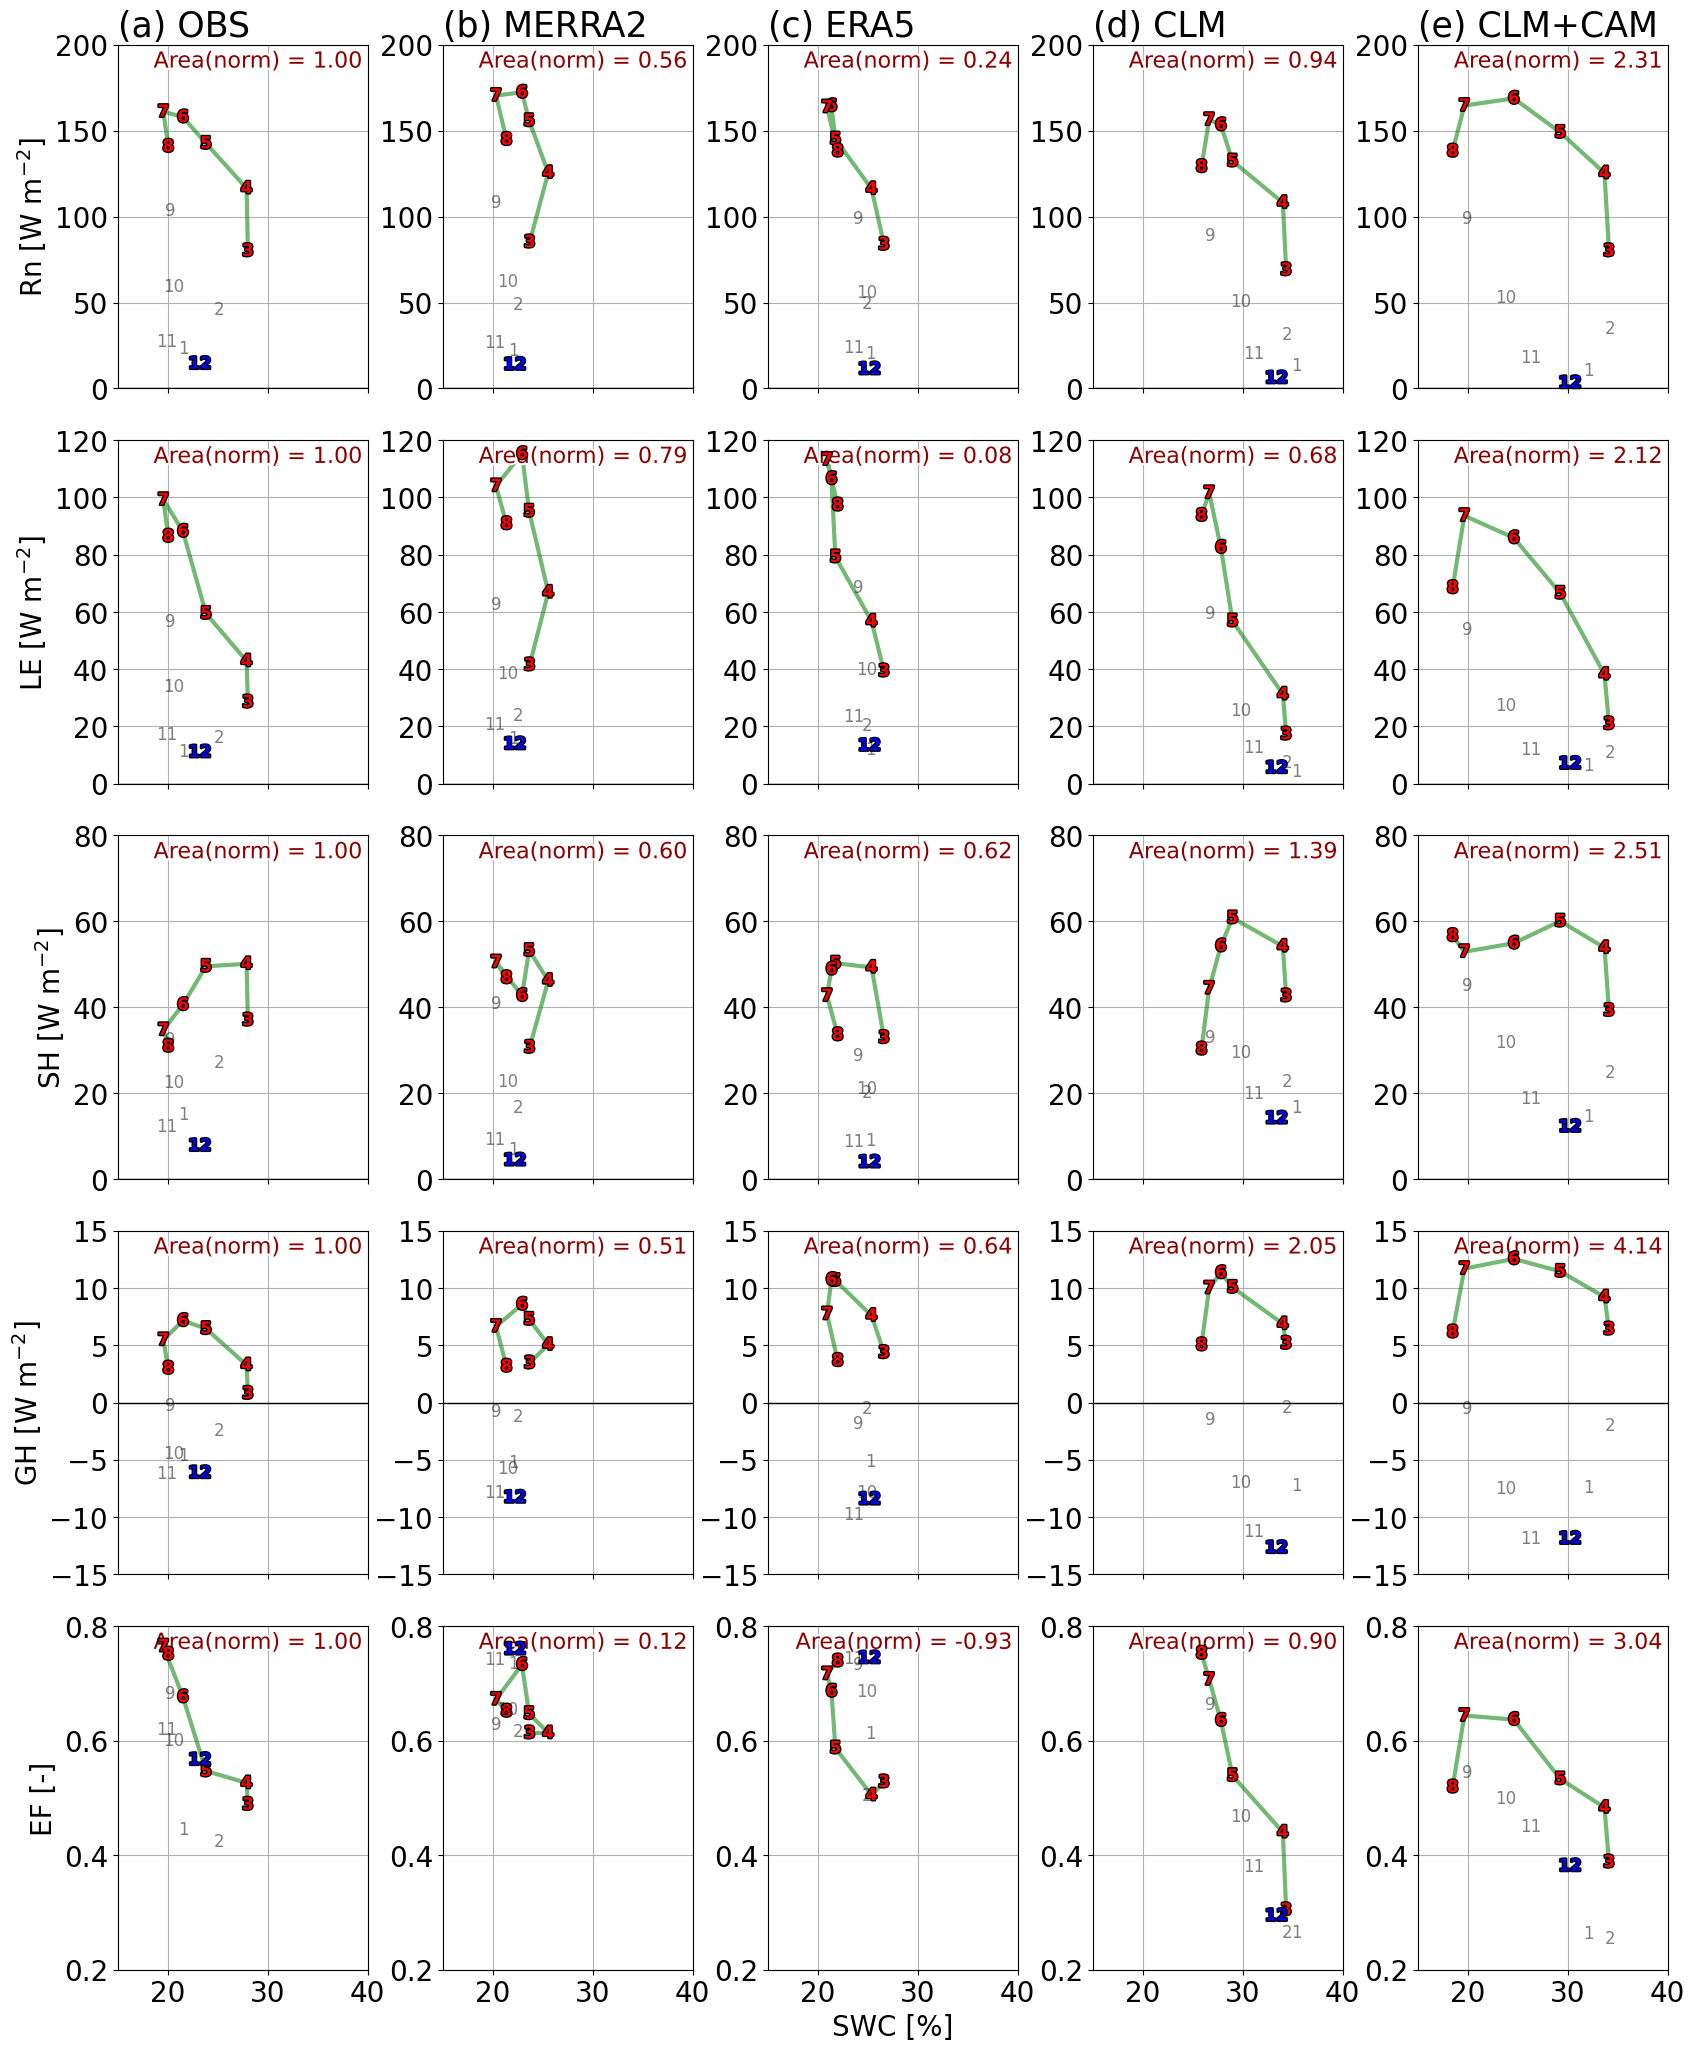

In [30]:
fig = plt.figure(figsize=(20,25))
gs  = fig.add_gridspec(5,5, hspace=0.15, wspace=0.3)
axs = gs.subplots(sharex=True)

for col, (dataset_name, data_dict) in enumerate(datasets.items()):
    for var_label, unit, row_idx, y_key in variables:
        ax = axs[row_idx, col]

        swc_array  = data_dict["swc"]
        flux_array = data_dict[y_key]

        # ==========================
        # (정규화된 area 불러오기)
        # ==========================
        area_norm = area_norm_df.loc[var_label, dataset_name]

        txt = ax.text(
            0.98, 0.98,
            f"Area(norm) = {area_norm:.2f}",
            transform=ax.transAxes,
            fontsize=16,
            ha="right", va="top",
            color="darkred"
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='white'),
            path_effects.Normal()
        ])

       # ==========================
        # (2) Scatter + month labels
        # ==========================
        for i, (x, y) in enumerate(zip(swc_array, flux_array)):
            annotate_month(ax, x, y, month_labels[i], i, fontsize=fontsize)

        # ==========================
        # (3) Cycle lines
        # ==========================
        swc_line  = cycle_data(swc_array)
        flux_line = cycle_data(flux_array)

        start_idx, end_idx = 3, 9
        ax.plot(
            swc_line[start_idx:end_idx],
            flux_line[start_idx:end_idx],
            color='green', linewidth=3, alpha=0.55)

        ax.yaxis.grid(True)
        ax.xaxis.grid(True)
        ax.tick_params(axis="both", which="major", labelsize=20)

        if row_idx == 0:
            ax.set_title(dataset_name, loc='left', fontsize=25)
        if col == 0:
            ax.set_ylabel(var_label + unit, fontsize=20)


#
for i in range(0,5):
    for j in range(0,5):
        axs[0,j].set_ylim(0, 200)
        axs[1,j].set_ylim(0, 120)
        axs[2,j].set_ylim(0,  80)
        axs[3,j].set_ylim(-15, 15)
        axs[4,j].set_ylim(0.20, 0.80)

        axs[i,j].set_xlim(15, 40)
        axs[i,j].hlines(0, 10, 50, color='black', linewidth=1)

        axs[4,j].yaxis.set_major_locator(ticker.MultipleLocator(0.2))

axs[4,2].set_xlabel('SWC [%]', fontsize=20)

# plt.tight_layout()
plt.show()
